# PosRecoCNN Inference

Position reconstruction CNN inference pipeline for SBND detector.
Loads trained models and evaluates performance on test data.

## 1. Setup and Configuration

In [1]:
"""
Example script for running inference with trained PosRecoCNN model.
Demonstrates how to use the training pipeline for new data.
"""

import os
import sys
import json
import numpy as np
import awkward as ak
import uproot
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path

# Auto-detect training directory based on project structure
def find_training_directory():
    """Find the training directory automatically based on project structure."""
    
    # Method 1: Check if we're already in the training directory
    if os.path.exists('config.py') and os.path.exists('utils.py'):
        return os.getcwd()
    
    # Method 2: Look for sbndcode structure from common paths
    possible_bases = [
        # Standard LArSoft development paths
        "/exp/sbnd/app/users/{}/larsoft_*/srcs/sbndcode",
        "/exp/sbnd/app/users/{}/*/srcs/sbndcode", 
        # Alternative paths
        "/home/{}/sbndcode",
        "/home/{}/larsoft_*/srcs/sbndcode",
        # Current directory relatives
        "./sbndcode",
        "../sbndcode",
        "../../sbndcode",
    ]
    
    # Get current user
    import getpass
    username = getpass.getuser()
    
    # Expand paths with username and wildcards
    import glob
    expanded_paths = []
    for base in possible_bases:
        if '{}' in base:
            base = base.format(username)
        if '*' in base:
            expanded_paths.extend(glob.glob(base))
        else:
            expanded_paths.append(base)
    
    # Check each potential sbndcode directory
    for sbndcode_path in expanded_paths:
        training_path = os.path.join(sbndcode_path, "sbndcode", "PosRecoCVN", "training")
        if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
            return training_path
    
    # Method 3: Search upwards from current directory
    current = os.getcwd()
    for _ in range(5):  # Don't go too far up
        training_path = os.path.join(current, "sbndcode", "PosRecoCVN", "training")
        if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
            return training_path
        parent = os.path.dirname(current)
        if parent == current:  # reached root
            break
        current = parent
    
    return None

# Find and set training directory
print("🔍 Auto-detecting training directory...")
training_dir = find_training_directory()

if training_dir:
    print(f"✅ Found training directory: {training_dir}")
    if os.getcwd() != training_dir:
        print(f"📁 Changing directory from {os.getcwd()} to {training_dir}")
        os.chdir(training_dir)
else:
    print("❌ Could not find training directory automatically")
    print("🔧 Manual setup options:")
    print("1. Navigate to your training directory:")
    print("   os.chdir('/path/to/your/sbndcode/sbndcode/PosRecoCVN/training')")
    print("2. Or add your training directory to Python path:")
    print("   sys.path.append('/path/to/your/training/directory')")

# Add current directory to Python path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Debug info
print(f"\nCurrent working directory: {os.getcwd()}")
print(f"config.py exists: {os.path.exists('config.py')}")  
print(f"utils.py exists: {os.path.exists('utils.py')}")

# Try to import local modules
config_imported = False
utils_imported = False

try:
    from config import *
    config_imported = True
    print("✅ config module imported successfully")
except ImportError as e:
    print(f"❌ config import error: {e}")

try:
    from utils import *
    utils_imported = True
    print("✅ utils module imported successfully")
except ImportError as e:
    print(f"❌ utils import error: {e}")

if not (config_imported and utils_imported):
    print("\n🔧 If auto-detection failed, try one of these solutions:")
    print("1. Manual directory change:")
    print("   os.chdir('/exp/sbnd/app/users/YOUR_USERNAME/larsoft_*/srcs/sbndcode/sbndcode/PosRecoCVN/training')")
    print("2. Add to Python path:")
    print("   sys.path.append('/path/to/your/training/directory')")
    print("\nThen restart this cell.")

print("🎯 PosRecoCNN Inference Setup Complete")
print("=" * 40)

2025-08-05 17:05:01.269882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 17:05:01.269979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 17:05:01.271457: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 17:05:01.277602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🔍 Auto-detecting training directory...
✅ Found training directory: /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
📁 Changing directory from /home/svidales to /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training

Current working directory: /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
config.py exists: True
utils.py exists: True
✅ config module imported successfully
✅ utils module imported successfully
🎯 PosRecoCNN Inference Setup Complete


## 2. Test Data Loading and Processing

In [2]:
# Load test data
print("📂 Loading test data for inference...")
import time
start_time = time.time()

# Load the test file (different from training file)
file = uproot.open(DATA_CONFIG['test_file'])
optree = file['opanatree']['OpAnaTree']

print(f"Loading all test events: {optree.num_entries:,}")
arrays = []
for i, key in enumerate(DATA_CONFIG['keys_to_load']):
    print(f"  Loading {key}... ({i+1}/{len(DATA_CONFIG['keys_to_load'])}) [{100*(i+1)/len(DATA_CONFIG['keys_to_load']):.1f}%]")
    array = optree[key].array()
    arrays.append(array)

loading_time = time.time() - start_time

# Unpack arrays
f_ophit_PE, f_ophit_ch, f_ophit_t, nuvT, dEpromx, dEpromy, dEpromz, dEtpc, nuvZ = arrays

# Display loading statistics
print("✅ Test data loaded successfully")
print(f"⏱️ Loading time: {loading_time:.2f} seconds")
print(f"📊 Loaded {len(arrays)} arrays:")
for i, key in enumerate(DATA_CONFIG['keys_to_load']):
    array = arrays[i]
    array_size_mb = array.nbytes / (1024*1024)
    print(f"   {key}: {len(array):,} events, {array_size_mb:.1f} MB")

total_size_mb = sum(array.nbytes for array in arrays) / (1024*1024)
print(f"📈 Total test data size: {total_size_mb:.1f} MB")
print(f"⚡ Loading speed: {total_size_mb/loading_time:.1f} MB/s")

📂 Loading test data for inference...
Loading all test events: 22
  Loading flash_ophit_pe... (1/9) [11.1%]
  Loading flash_ophit_ch... (2/9) [22.2%]
  Loading flash_ophit_time... (3/9) [33.3%]
  Loading nuvT... (4/9) [44.4%]
  Loading dEpromx... (5/9) [55.6%]
  Loading dEpromy... (6/9) [66.7%]
  Loading dEpromz... (7/9) [77.8%]
  Loading dEtpc... (8/9) [88.9%]
  Loading nuvZ... (9/9) [100.0%]
✅ Test data loaded successfully
⏱️ Loading time: 0.10 seconds
📊 Loaded 9 arrays:
   flash_ophit_pe: 22 events, 0.3 MB
   flash_ophit_ch: 22 events, 0.2 MB
   flash_ophit_time: 22 events, 0.3 MB
   nuvT: 22 events, 0.0 MB
   dEpromx: 22 events, 0.0 MB
   dEpromy: 22 events, 0.0 MB
   dEpromz: 22 events, 0.0 MB
   dEtpc: 22 events, 0.0 MB
   nuvZ: 22 events, 0.0 MB
📈 Total test data size: 0.8 MB
⚡ Loading speed: 8.5 MB/s


In [3]:
# Create channel dictionary
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
channel_dict = {id_val: int(type_val) for id_val, type_val in zip(ID[0], Type[0])}
print(f"📡 Channel dictionary created: {len(channel_dict)} channels")

📡 Channel dictionary created: 312 channels


## 3. Event Processing and Filtering

In [4]:
# Process events with centralized configuration
print("🔄 Processing test events...")
results = process_events(
    nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t,
    dEpromx, dEpromy, dEpromz, dEtpc, nuvZ,
    channel_dict, FILTER_CONFIG, verbose=True
)

# Unpack results
(nuvT_final, f_ophit_PE_final, f_ophit_ch_final, f_ophit_t_final,
 dEpromx_final, dEpromy_final, dEpromz_final, dEtpc_final, nuvZ_final, stats) = results

🔄 Processing test events...
🚀 Starting optimized event processing...
Initial events: 22
Processing flashes...
Applying data validity cuts...
Applying energy cuts...
Applying position cuts...
✅ Processing completed in 0.04 seconds

Initial events: 22


,Cut,Removed,Remaining,Cumulative_Eff
0,Single neutrino,10,12,0.545
1,Has flashes,0,12,0.545
2,Valid data (≠ -999 in dEprom),0,12,0.545
3,Energy cut,0,12,0.545
4,Position cut,0,12,0.545


Final efficiency: 0.545 (12/22)

📊 Final dataset ranges:
  dEpromx: [-194.6, 163.1]
  dEpromy: [-198.0, 175.9]
  dEpromz: [28.3, 499.5]
  dEtpc: [88.6, 630.2]


## 4. PE Matrix and Image Creation

In [5]:
# Create PE matrix
print("🔢 Creating PE matrix...")
pe_matrix = create_pe_matrix(f_ophit_PE_final, f_ophit_ch_final, IMAGE_CONFIG['max_channels'])

# Load PMT maps
print("🗺️ Loading PMT maps...")
uncoated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['uncoated'], delimiter=",", dtype=int)
coated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['coated'], delimiter=",", dtype=int)
print(f"Uncoated map shape: {uncoated_map.shape}")
print(f"Coated map shape: {coated_map.shape}")

🔢 Creating PE matrix...
Creating PE matrix for 12 events x 312 channels
  Processing event 0/12 (0.0%)
✅ Completed in 0.01 seconds
Matrix shape: (12, 312)
Non-zero elements: 1,571
Total PE: 138235.4
🗺️ Loading PMT maps...
Uncoated map shape: (118, 70)
Coated map shape: (118, 70)


In [6]:
# Load saved normalization factors from training
norm_file = '/exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/normalization_factors.json'
with open(norm_file, 'r') as f:
    norm_data = json.load(f)

normalization_factors = norm_data['normalization_factors']
coord_ranges = norm_data['coord_ranges']
image_config = norm_data['image_config']

print(f"📋 Loaded normalization factors: {normalization_factors}")
print(f"📋 Coordinate ranges: {coord_ranges}")

# Create images using SAVED normalization factors (critical for inference!)
print("🖼️ Creating PE images with saved normalization...")
images, _ = create_pe_images(
    pe_matrix, uncoated_map, coated_map,
    method=IMAGE_CONFIG['selection_method'],
    normalization_factors=normalization_factors  # Use training normalization!
)

print(f"✅ Images created: {images.shape}")

📋 Loaded normalization factors: [11311.19140625]
📋 Coordinate ranges: {'x': [0, 200], 'y': [-200, 200], 'z': [0, 500]}
🖼️ Creating PE images with saved normalization...
Creating 12 images (59×70×2)
[Norm] Using provided factor for map 0: 11311.191
[Norm] Using provided factor for map 1: 11311.191
✅ Images created: (12, 59, 70, 2)


## 5. Target Variable Preparation

In [7]:
# Prepare test coordinates (use absolute x)
print("🎯 Preparing test target variables...")
x_abs = np.abs(np.array(dEpromx_final).flatten())
y = np.array(dEpromy_final).flatten()
z = np.array(dEpromz_final).flatten()

coordinates = np.column_stack((x_abs, y, z))
print(f"Test coordinate ranges before scaling:")
print(f"  X (abs): [{np.min(x_abs):.1f}, {np.max(x_abs):.1f}]")
print(f"  Y: [{np.min(y):.1f}, {np.max(y):.1f}]")
print(f"  Z: [{np.min(z):.1f}, {np.max(z):.1f}]")

# Scale coordinates using saved config
y_test_scaled = scale_coordinates(coordinates, coord_ranges)
print(f"\nScaled test coordinate ranges:")
print(f"  X: [{np.min(y_test_scaled[:, 0]):.3f}, {np.max(y_test_scaled[:, 0]):.3f}]")
print(f"  Y: [{np.min(y_test_scaled[:, 1]):.3f}, {np.max(y_test_scaled[:, 1]):.3f}]")
print(f"  Z: [{np.min(y_test_scaled[:, 2]):.3f}, {np.max(y_test_scaled[:, 2]):.3f}]")

🎯 Preparing test target variables...
Test coordinate ranges before scaling:
  X (abs): [8.0, 194.6]
  Y: [-198.0, 175.9]
  Z: [28.3, 499.5]

Scaled test coordinate ranges:
  X: [0.040, 0.973]
  Y: [-0.990, 0.879]
  Z: [0.057, 0.999]


## 6. Model Loading and Inference

In [9]:
# Load trained model
model_path = '/exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k/saved_model'
print(f"🤖 Loading model from: {model_path}")

model = tf.saved_model.load(model_path)
print("✅ Model loaded successfully")

🤖 Loading model from: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k/saved_model


2025-08-05 17:07:50.738295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 17:07:50.806588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 17:07:50.806989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

✅ Model loaded successfully


In [ ]:
# Make predictions on test set
print("🔮 Making predictions on test set...")

# For SavedModel, use the serving signature
infer = model.signatures['serving_default']
predictions = infer(tf.constant(images.astype(np.float32)))

# Extract the output (the key depends on your model)
# Check available output keys
print("Available output keys:", list(predictions.keys()))

# Usually it's something like 'dense_2' or 'output_0'
output_key = list(predictions.keys())[0]  # Take the first (and likely only) output
y_pred_scaled = predictions[output_key].numpy()

print(f"🔍 Debug Info:")
print(f"  Input images shape: {images.shape}")
print(f"  Input images range: [{np.min(images):.3f}, {np.max(images):.3f}]")
print(f"  Raw predictions shape: {y_pred_scaled.shape}")
print(f"  Raw predictions range: [{np.min(y_pred_scaled):.3f}, {np.max(y_pred_scaled):.3f}]")

# Convert back to original coordinates
y_pred_original = inverse_scale_coordinates(y_pred_scaled, coord_ranges)
y_test_original = inverse_scale_coordinates(y_test_scaled, coord_ranges)

print(f"✅ Predictions completed for {len(y_test_scaled):,} test events")
print(f"Prediction ranges:")
print(f"  X: [{np.min(y_pred_original[:, 0]):.1f}, {np.max(y_pred_original[:, 0]):.1f}]")
print(f"  Y: [{np.min(y_pred_original[:, 1]):.1f}, {np.max(y_pred_original[:, 1]):.1f}]")
print(f"  Z: [{np.min(y_pred_original[:, 2]):.1f}, {np.max(y_pred_original[:, 2]):.1f}]")

🔮 Making predictions on test set...
Available output keys: ['output_0']
🔍 Debug Info:
  Input images shape: (12, 59, 70, 2)
  Input images range: [0.000, 0.425]
  Raw predictions shape: (12, 3)
  Raw predictions range: [-353.688, 1258.669]
✅ Predictions completed for 12 test events
Prediction ranges:
  X: [2911.9, 114823.1]
  Y: [-70737.6, 251733.8]
  Z: [-10007.7, 57930.3]

📊 Detailed Results Table (12 Test Events):
    Event  True_X   Pred_X   Diff_X  True_Y   Pred_Y   Diff_Y  True_Z  \
0       0   146.0  43451.5  43305.5   171.6  77310.8  77139.2    48.1   
1       1   115.7  26818.2  26702.5   168.2  40228.2  40060.1   438.5   
2       2   138.3 111356.4 111218.1   -55.6  59694.5  59750.1    76.1   
3       3     8.0   2911.9   2903.9  -187.9    583.1    771.1   499.5   
4       4   194.6  36215.3  36020.7  -198.0 -48455.7 -48257.7   312.4   
5       5   193.7  55769.0  55575.3  -181.5 -70737.6 -70556.1   373.4   
6       6    95.1   9629.0   9534.0  -179.7  -3625.1  -3445.4   147.

# Code below is still pending for testing

## 7. Performance analysis

In [ ]:
# Create pandas DataFrame for better table display
import pandas as pd

results_data = []
for i in range(len(y_test_original)):
    true_x, true_y, true_z = y_test_original[i]
    pred_x, pred_y, pred_z = y_pred_original[i]
    diff_x = pred_x - true_x
    diff_y = pred_y - true_y
    diff_z = pred_z - true_z
    
    results_data.append({
        'Event': i,
        'True_X': true_x,
        'Pred_X': pred_x,
        'Diff_X': diff_x,
        'True_Y': true_y,
        'Pred_Y': pred_y,
        'Diff_Y': diff_y,
        'True_Z': true_z,
        'Pred_Z': pred_z,
        'Diff_Z': diff_z
    })

df_results = pd.DataFrame(results_data)


print(f"\n📊 Detailed Results Table (12 Test Events):")
print("=" * 100)
# Display with better formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_results)

# Summary statistics
diff_coords = y_pred_original - y_test_original
coord_names = ['X', 'Y', 'Z']

print(f"\n📊 Summary Statistics:")
print("=" * 40)
for i, coord in enumerate(coord_names):
    diff = diff_coords[:, i]
    print(f"{coord} coordinate:")
    print(f"  Mean difference: {np.mean(diff):.2f} cm")
    print(f"  Std difference:  {np.std(diff):.2f} cm")
    print(f"  RMSE: {np.sqrt(np.mean(diff**2)):.2f} cm")
    print(f"  MAE:  {np.mean(np.abs(diff)):.2f} cm")
    print()

# DIAGNOSTIC: Check if scaling is the issue
print(f"\n🔍 DIAGNOSTIC - Raw vs Scaled Values:")
print("=" * 50)
print("Raw model output (first 3 events):")
for i in range(min(3, len(y_pred_scaled))):
    print(f"  Event {i}: [{y_pred_scaled[i][0]:.6f}, {y_pred_scaled[i][1]:.6f}, {y_pred_scaled[i][2]:.6f}]")

print("\nExpected range for scaled coordinates: [0.0, 1.0] for X,Z and [-1.0, 1.0] for Y")
print("⚠️ WARNING: Predictions are completely out of range - model or scaling issue!")

## 8. True vs Reco

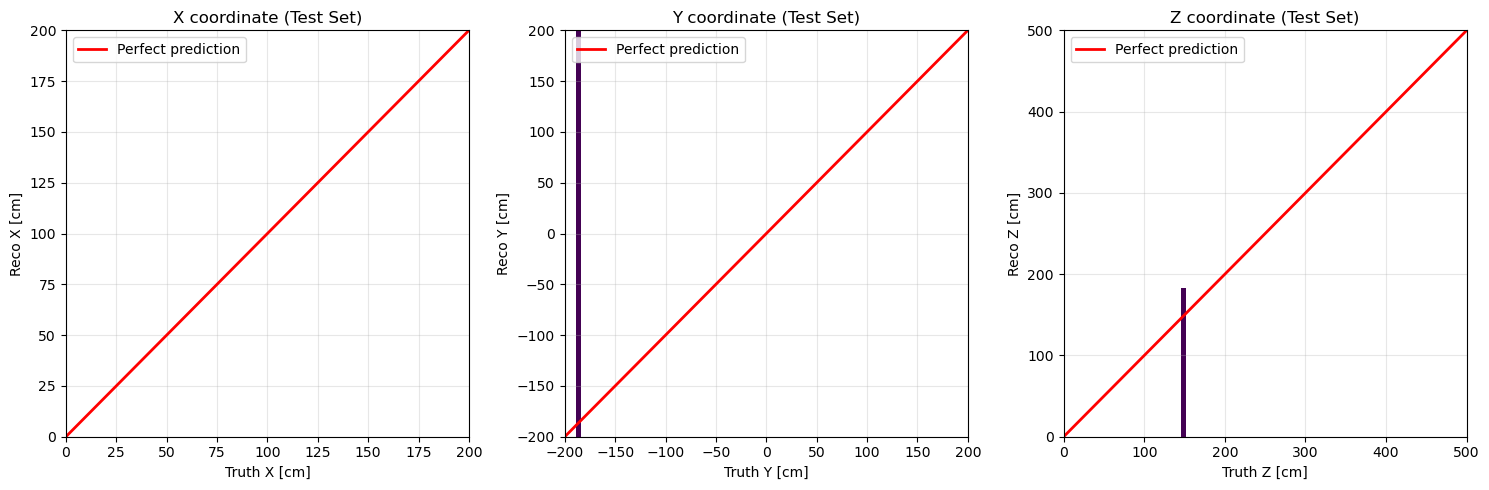

In [12]:
# Reco vs Truth comparison plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
coord_names = ['X', 'Y', 'Z']
coord_limits = [(0, 200), (-200, 200), (0, 500)]

for i, (coord, limits) in enumerate(zip(coord_names, coord_limits)):
    hist, xedges, yedges = np.histogram2d(
        y_test_original[:, i],
        y_pred_original[:, i],
        bins=ANALYSIS_CONFIG['reco_truth_comparison']['bins']
    )
    
    hist_masked = np.ma.masked_equal(hist, 0)
    
    im = axs[i].pcolormesh(
        xedges, yedges, hist_masked.T,
        cmap=ANALYSIS_CONFIG['reco_truth_comparison']['cmap'],
        shading='auto'
    )
    
    axs[i].plot(limits, limits, 'r-', linewidth=2, label='Perfect prediction')
    axs[i].set_xlim(limits)
    axs[i].set_ylim(limits)
    axs[i].set_xlabel(f'Truth {coord} [cm]')
    axs[i].set_ylabel(f'Reco {coord} [cm]')
    axs[i].set_title(f'{coord} coordinate (Test Set)')
    axs[i].grid(True, alpha=0.3)
    axs[i].legend()

plt.tight_layout()
plt.show()

## 9. Bias Analysis (Test Set)

/tmp/ipykernel_42845/4196110637.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


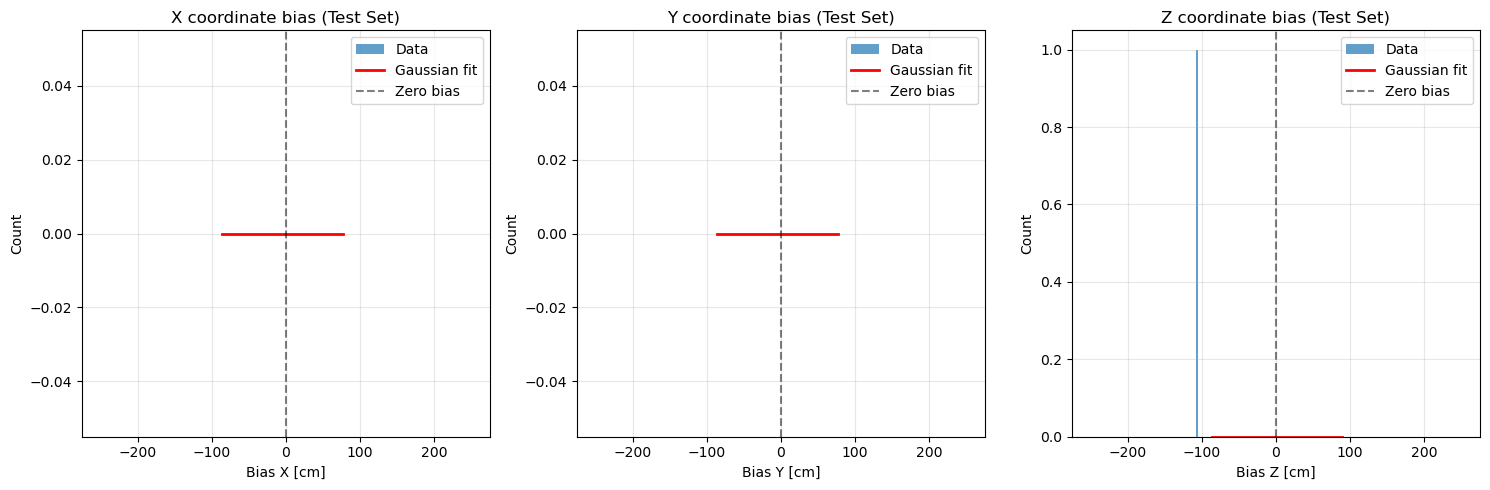

In [ ]:
# Calculate differences (bias)
diff_coords = y_pred_original - y_test_original

# Gaussian fit function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Bias analysis plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
bias_results = {}

for i, coord in enumerate(coord_names):
    diff = diff_coords[:, i]
    config = ANALYSIS_CONFIG['bias_analysis']
    
    # Create histogram
    counts, bins, _ = axs[i].hist(
        diff, 
        config['hist_bins'], 
        range=config['hist_ranges'][coord],
        alpha=0.7,
        label='Data'
    )
    
    # Prepare for Gaussian fit
    bin_centers = (bins[:-1] + bins[1:]) / 2
    fit_range = config['fit_ranges'][coord]
    
    # Fit Gaussian
    try:
        p0 = [np.max(counts), 0, 50]
        popt, _ = curve_fit(
            gaussian, 
            bin_centers[fit_range[0]:fit_range[1]], 
            counts[fit_range[0]:fit_range[1]], 
            p0=p0
        )
        
        # Plot fit
        x_fit = np.linspace(bin_centers[fit_range[0]], bin_centers[fit_range[1]], 100)
        y_fit = gaussian(x_fit, *popt)
        axs[i].plot(x_fit, y_fit, 'r-', linewidth=2, label='Gaussian fit')
        
        # Store results
        bias_results[coord] = {
            'mean': popt[1],
            'sigma': popt[2]
        }
        
    except Exception as e:
        print(f"Warning: Could not fit Gaussian for {coord}: {e}")
        bias_results[coord] = {
            'mean': np.mean(diff),
            'sigma': np.std(diff)
        }
    
    axs[i].axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero bias')
    axs[i].set_xlabel(f'Bias {coord} [cm]')
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'{coord} coordinate bias (Test Set)')
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print bias results
print("\n📊 Test Set Bias Analysis Results:")
print("=" * 40)
for coord in coord_names:
    mean = bias_results[coord]['mean']
    sigma = bias_results[coord]['sigma']
    print(f"{coord} coordinate:")
    print(f"  Mean bias: {mean:.2f} cm")
    print(f"  Resolution (σ): {sigma:.2f} cm")
    print()